In [1]:
import random
import colorsys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc

from adjustText import adjust_text
from matplotlib.lines import Line2D # for the legend
from sklearn.linear_model import LinearRegression

# 设置随机种子以确保结果可复现
np.random.seed(42)

参考：https://wilkelab.org/practicalgg/index.html

## 模拟数据

In [2]:
# 生成 300 个数据
countries = [f'Country_{i}' for i in range(1, 301)]
iso3c_codes = [f'C_{i:03d}' for i in range(1, 301)]
regions = ['Region_A', 'Region_B', 'Region_C', 'Region_D', 'Region_E']
hdi_values = np.random.uniform(0.3, 0.95, 300)
a, b = 2, 2 
noise = np.random.normal(0, 0.5, 300)  
cpi_values = a * np.exp(b * hdi_values) + noise
cpi_values = np.clip(cpi_values, 0, None) 

# 构造 DataFrame
df = pd.DataFrame({
    'country': countries,
    'region': np.random.choice(regions, 300),
    'cpi': cpi_values,
    'iso3c': iso3c_codes,
    'hdi': hdi_values
})

df

,country,region,cpi,iso3c,hdi
0,Country_1,Region_C,5.952935,C_001,0.543451
1,Country_2,Region_D,12.216109,C_002,0.917964
2,Country_3,Region_E,10.509927,C_003,0.775796
3,Country_4,Region_C,8.252911,C_004,0.689128
4,Country_5,Region_C,3.451099,C_005,0.401412
...,...,...,...,...,...
295,Country_296,Region_D,7.209530,C_296,0.639458
296,Country_297,Region_A,10.045754,C_297,0.800496
297,Country_298,Region_B,4.372377,C_298,0.440284
298,Country_299,Region_A,8.509222,C_299,0.704879


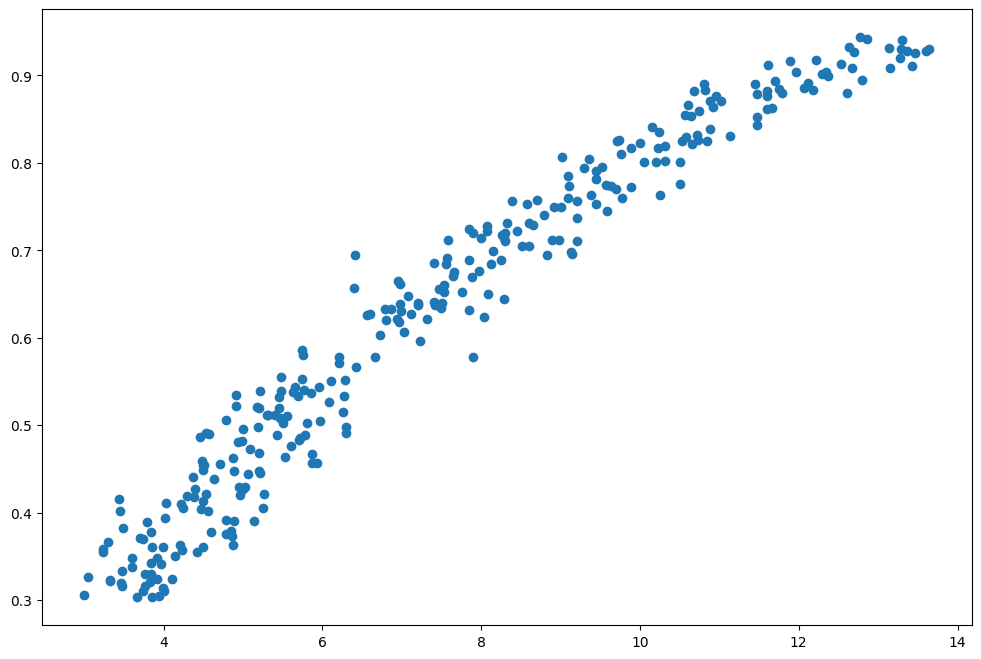

In [3]:
plt.figure(figsize=(12, 8))
plt.scatter(df.cpi, df.hdi)
plt.show()

## 图形颜色

In [4]:
def adjust_lightness(color: str, amount: float=0.5) -> tuple:
    """
    调整颜色的亮度（Lightness）。
    
    参数:
    color (str): 颜色名称或十六进制代码，如 "blue" 或 "#1f77b4"
    amount (float): 亮度调整比例，>1 变亮，<1 变暗，默认 0.5
    
    返回:
    tuple: 调整后的 RGB 颜色值 (r, g, b)
    """
    try:
        c = mc.CSS4_COLORS.get(color, color)
        rgb = mc.to_rgb(c)
    except ValueError:
        raise ValueError(f"Invalid color input: {color}")
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * amount))

    return colorsys.hls_to_rgb(h, l, s)

In [5]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]  # Okabe Ito colors
categories = pd.Categorical(df["region"]).codes  # 类别编码
colors1 = np.array(colors)[categories]  # 图像颜色
edgecolors = [adjust_lightness(color, 0.6) for color in colors1]  # 边颜色
regions = df.region.unique()  # 地区类别

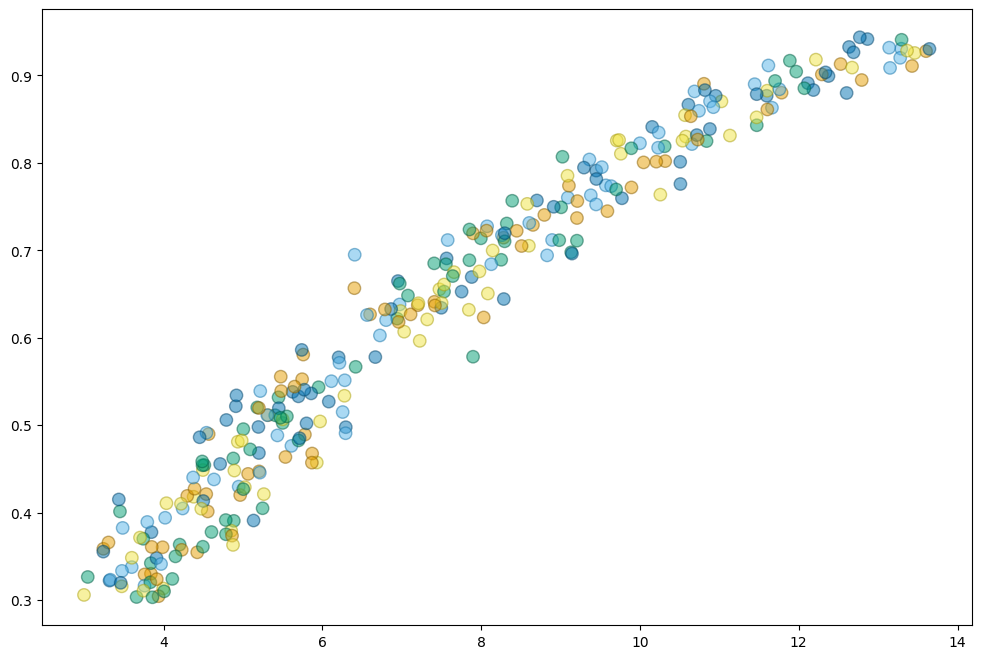

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(
    df.cpi, df.hdi, color=colors1, edgecolors=edgecolors,
    s=80, alpha=0.5, zorder=10
)
plt.show()

## 拟合曲线

In [7]:
X = df.cpi.values.reshape(-1, 1)
y = df.hdi.values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(np.log(X), y)
x_pred = np.log(np.linspace(3, 14, num=200).reshape(-1, 1))
y_pred = linear_regressor.predict(x_pred)

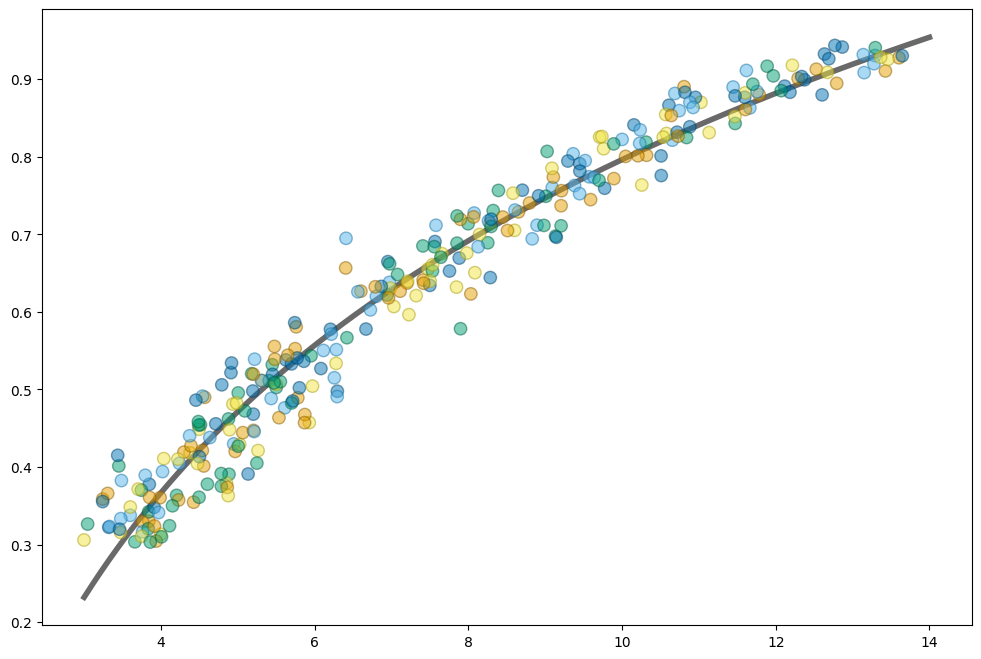

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(
    df.cpi, df.hdi, color=colors1, edgecolors=edgecolors,
    s=80, alpha=0.5, zorder=10
)
plt.plot(np.exp(x_pred), y_pred, color="#696969", lw=4)
plt.show()

## 定义函数

In [9]:
def plot_(colors: list, edgecolors: list, colors_legend: list, regions: list, x_pred: np.array, y_pred: np.array) -> None:

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(
        df.cpi, df.hdi, color=colors, edgecolors=edgecolors,
        s=80, alpha=0.5, zorder=10
    )
    ax.plot(np.exp(x_pred), y_pred, color="#696969", lw=4)

    # 根据自己的数据调整
    ax.set_ylim(0.25, 1.05)
    ax.set_yticks([0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(2, 15)
    ax.set_xticks([4, 6, 8, 10, 12, 14])

    # 轴的设置
    ax.grid(axis="y")
    ax.spines["left"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.tick_params(axis="both", length=0)  # 去掉 x 和 y 轴的刻度线
    ax.set_xlabel("Corruption Perceptions Index(CPI), year (100 = least corrupt)")
    ax.set_ylabel("Human Development Index(HDI), year\n(1.0 = most developed)")

    # 创建图例句柄（markers）
    handles = [
        Line2D(
            [], [], label=label, 
            lw=0,  # 没有线条，仅显示标记
            marker="o",  
            markersize=10,  
            markerfacecolor=colors_legend[idx],  
            # markeredgecolor="grey"  # 可选：增加边框以便查看透明效果
        )
        for idx, label in enumerate(regions)
    ]
    handles += [Line2D([], [], label="y ~ log(x)", color="#696969", lw=2)]  # 追加用于曲线的句柄
    # 添加图例
    legend = fig.legend(
        handles=handles,
        bbox_to_anchor=[0.5, 0.95],  # 位于顶部中央
        fontsize=12,
        handletextpad=0.6,  # 文本与标记之间的间距
        handlelength=1.4,  
        columnspacing=1.4,
        loc="center",  
        ncol=6,
        frameon=False
    )
    # 设置透明度
    for i in range(min(5, len(handles))):  # 确保不会超出索引
        handles[i].set_alpha(0.5)  # 直接修改透明度

    plt.show()

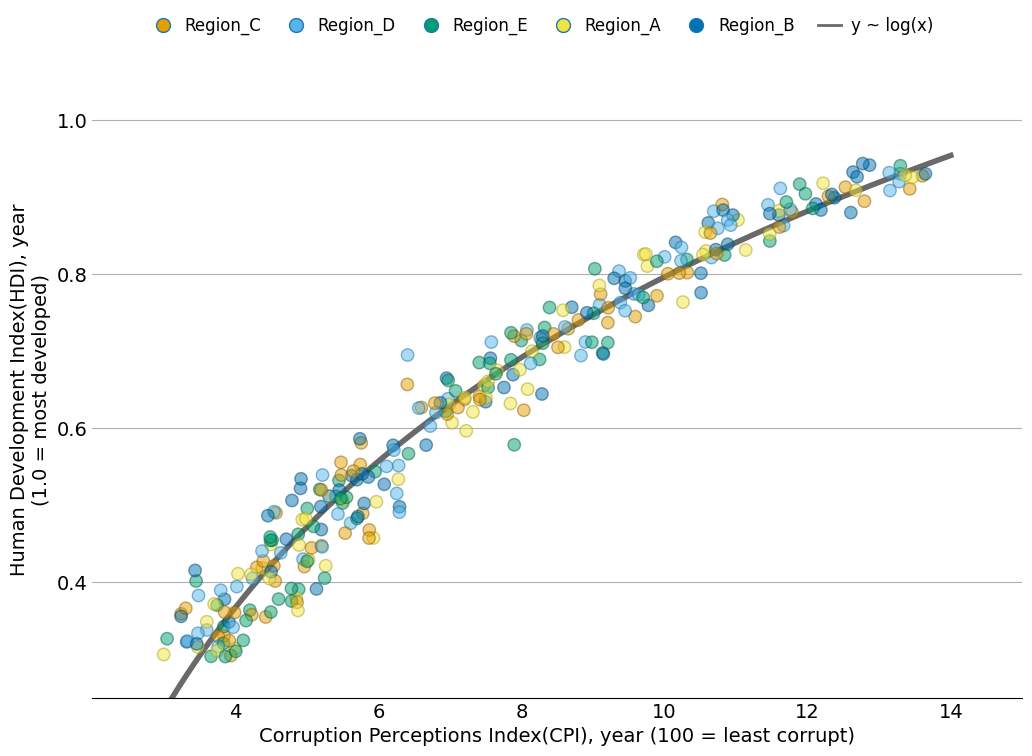

In [10]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]  # Okabe Ito colors
categories = pd.Categorical(df["region"]).codes  # 类别编码
colors1 = np.array(colors)[categories]  # 图像颜色
edgecolors = [adjust_lightness(color, 0.6) for color in colors1]  # 边颜色
regions = df.region.unique()  # 地区类别
x_pred, y_pred

plt.rcParams.update({"font.size": "14"})

plot_(colors=colors1, edgecolors=edgecolors, colors_legend=colors, regions=regions, x_pred=x_pred, y_pred=y_pred)